# ZzzSafe - Approach 5: Blurriness Detection 📸💤
---
**Objective:** Detect if a driver is drowsy by checking if the frame/image is blurry.
We assume that drowsy drivers may close their eyes or lose focus, resulting in blurred images.
---

# **1. Dataset Download & Setup**

Downloading Driver Drowsiness Datasets from Kaggle Hub

Downloads two standard drowsiness detection datasets (DDD and NTHUDDD2) from Kaggle Hub for analysis.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

100%|██████████| 2.58G/2.58G [00:32<00:00, 86.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1


# 2. Dataset Standardization & Merging

Standardizing and Merging Multiple Drowsiness Datasets

Combines datasets with different labeling conventions into a unified structure (e.g., converting "drowsy" → "Drowsy") for consistency.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("banudeep/nthuddd2")

print("Path to dataset files:", path)

100%|██████████| 2.81G/2.81G [00:31<00:00, 94.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1


# 3. Dataset Visualization & Exploration

Exploratory Data Analysis: Class Distribution & Sample Images

Visualizes the dataset’s class balance and displays random samples to understand data characteristics.

In [ ]:
import os
import shutil

def standardize_and_merge(dataset_a, dataset_b, output_path):
    label_mapping = {
        "Drowsy": "Drowsy",
        "drowsy": "Drowsy",
        "Non Drowsy": "Non Drowsy",
        "notdrowsy": "Non Drowsy"
    }

    for standard_label in set(label_mapping.values()):
        os.makedirs(os.path.join(output_path, standard_label), exist_ok=True)

    def copy_with_rename(source_root):
        for folder_name in os.listdir(source_root):
            source_folder = os.path.join(source_root, folder_name)
            if not os.path.isdir(source_folder):
                continue

            if folder_name not in label_mapping:
                print(f"Skipping unknown class: {folder_name}")
                continue

            target_folder = os.path.join(output_path, label_mapping[folder_name])
            for fname in os.listdir(source_folder):
                src = os.path.join(source_folder, fname)
                dst = os.path.join(target_folder, fname)

                if os.path.exists(dst):
                    base, ext = os.path.splitext(fname)
                    dst = os.path.join(target_folder, f"{base}_copy{ext}")
                shutil.copy2(src, dst)

    copy_with_rename(dataset_a)
    copy_with_rename(dataset_b)
    print("Datasets successfully standardized and merged!")

dataset_a = "/root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)"
dataset_b = "/root/.cache/kagglehub/datasets/banudeep/nthuddd2/versions/1/train_data"
combined = "/content/Final_DataSet"

standardize_and_merge(dataset_a, dataset_b, combined)

Datasets successfully standardized and merged!


# 4. Blurriness Analysis for Drowsiness Detection

Quantifying Image Blurriness Using Multiple Metrics (Laplacian, Tenengrad, Sobel

Computes three blur detection scores for each image to identify potential drowsiness (closed eyes/blurred frames).

<ipython-input-34-0ba434f6b6af>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


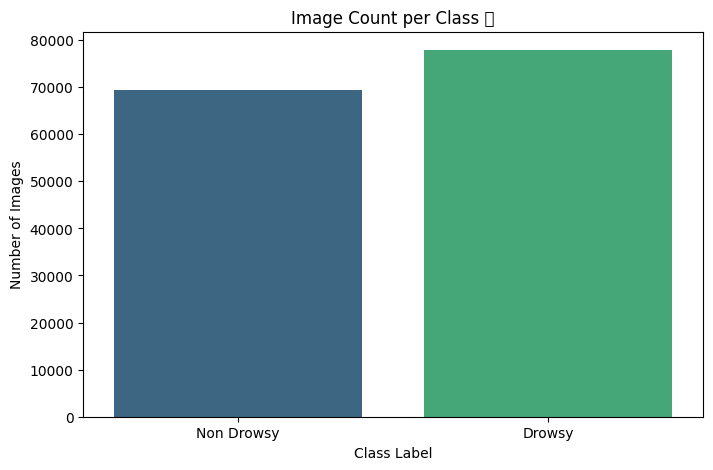

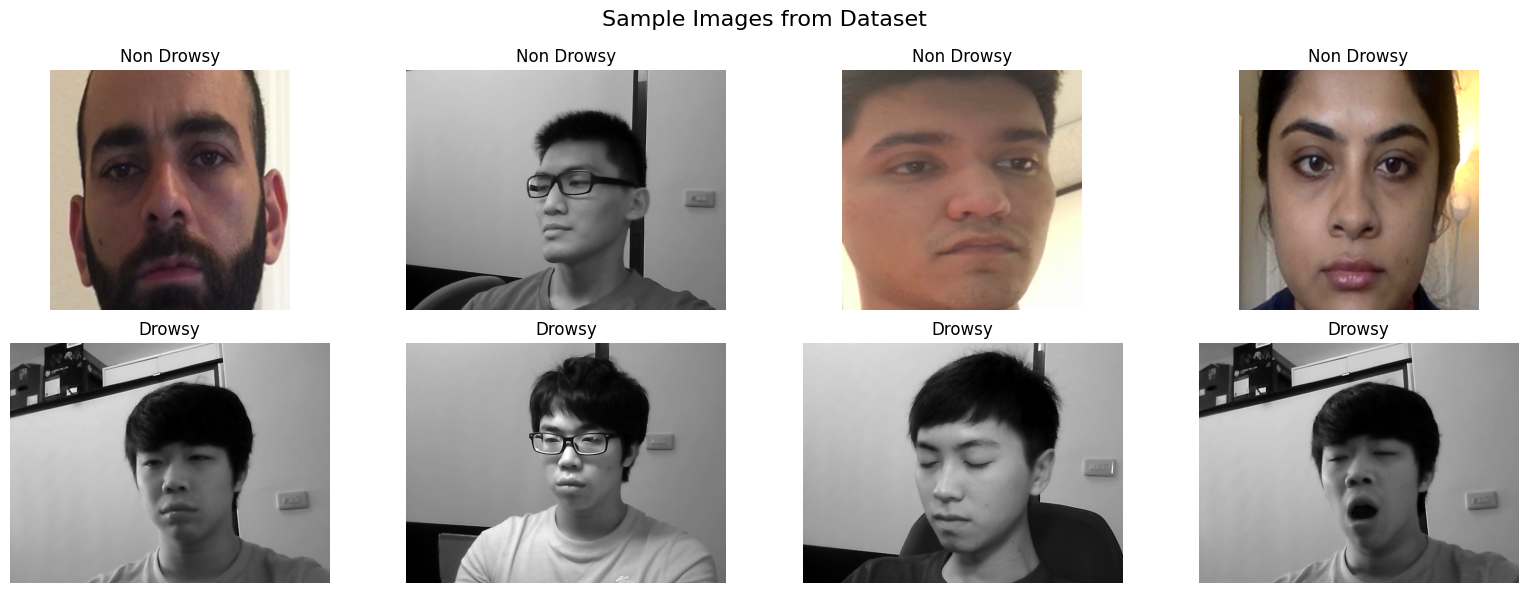

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

def visualize_dataset(dataset_path):
    class_names = os.listdir(dataset_path)
    class_counts = {}

    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Image Count per Class 📸")
    plt.ylabel("Number of Images")
    plt.xlabel("Class Label")
    plt.show()

    sample_images = []
    for class_name in class_names:
        class_folder = os.path.join(dataset_path, class_name)
        images = os.listdir(class_folder)
        selected = random.sample(images, min(4, len(images)))
        for img_name in selected:
            img_path = os.path.join(class_folder, img_name)
            sample_images.append((img_path, class_name))


    plt.figure(figsize=(16, 6))
    for idx, (img_path, label) in enumerate(sample_images[:8]):
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Unable to load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)

    plt.suptitle("Sample Images from Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_dataset("/content/Final_DataSet")


# 5. Real-Time Drowsiness Detection System

Real-Time Driver Drowsiness Detection via Blurriness Analysis

Implements a live webcam system that alerts when blurred frames (indicating drowsiness) are detected, with:

Multi-method blur detection (Laplacian, Tenengrad, Sobel)

Alert thresholds and smoothing logic

Debug mode for performance metrics

Total images found: 147261


Analyzing blurriness: 100%|██████████| 147261/147261 [20:55<00:00, 117.34it/s]


Blur scores saved to multi_blur_scores.csv


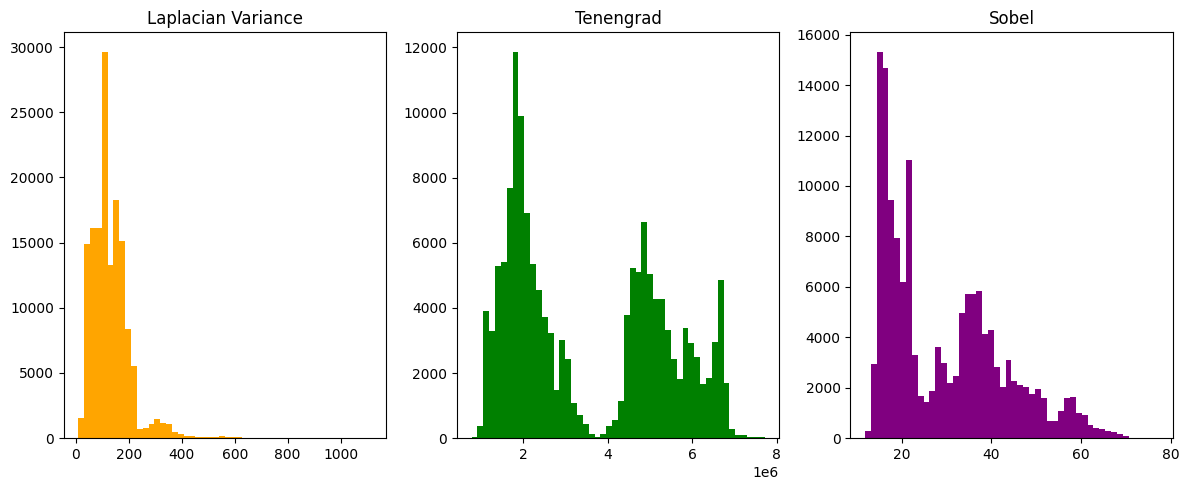

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

data_path = "/content/Final_DataSet"
image_paths = []


for root, _, files in os.walk(data_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print(f"Total images found: {len(image_paths)}")



def variance_of_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def tenengrad(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    return np.sqrt(gx**2 + gy**2).sum()

def sobel_blur_score(img):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return np.mean(np.sqrt(sobelx**2 + sobely**2))


results = []

for img_path in tqdm(image_paths, desc="Analyzing blurriness"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    lap = variance_of_laplacian(img)
    ten = tenengrad(img)
    sob = sobel_blur_score(img)

    results.append((img_path, lap, ten, sob))


df = pd.DataFrame(results, columns=["Path", "Laplacian", "Tenengrad", "Sobel"])
df.to_csv("multi_blur_scores.csv", index=False)
print("Blur scores saved to multi_blur_scores.csv")


plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.hist(df["Laplacian"], bins=50, color='orange')
plt.title("Laplacian Variance")

plt.subplot(1, 3, 2)
plt.hist(df["Tenengrad"], bins=50, color='green')
plt.title("Tenengrad")

plt.subplot(1, 3, 3)
plt.hist(df["Sobel"], bins=50, color='purple')
plt.title("Sobel")

plt.tight_layout()
plt.show()


# Deployment (Real-time detection system)

In [ ]:
import cv2
import numpy as np
import time
from collections import deque

class ZzzSafeRealTime:
    def __init__(self):

        self.laplacian_threshold = 100
        self.tenengrad_threshold = 20000
        self.sobel_threshold = 15


        self.prediction_history = deque(maxlen=10)


        self.fps_history = deque(maxlen=30)
        self.blur_scores = {
            "laplacian": deque(maxlen=100),
            "tenengrad": deque(maxlen=100),
            "sobel": deque(maxlen=100)
        }


        self.show_debug = True
        self.alert_active = False
        self.alert_start_time = 0
        self.drowsy_duration = 0

    def variance_of_laplacian(self, img):
        """Calculate the Laplacian variance to detect blur."""
        return cv2.Laplacian(img, cv2.CV_64F).var()

    def tenengrad(self, img):
        """Calculate Tenengrad score for blur detection."""
        gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        return np.sqrt(gx**2 + gy**2).sum()

    def sobel_blur_score(self, img):
        """Calculate Sobel-based blur score."""
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        return np.mean(np.sqrt(sobelx**2 + sobely**2))

    def detect_drowsiness(self, frame):
        """Detect drowsiness by analyzing frame blurriness."""

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


        lap_score = self.variance_of_laplacian(gray)
        ten_score = self.tenengrad(gray)
        sob_score = self.sobel_blur_score(gray)


        self.blur_scores["laplacian"].append(lap_score)
        self.blur_scores["tenengrad"].append(ten_score)
        self.blur_scores["sobel"].append(sob_score)


        is_drowsy = (
            lap_score < self.laplacian_threshold or
            ten_score < self.tenengrad_threshold or
            sob_score < self.sobel_threshold
        )


        self.prediction_history.append(is_drowsy)


        drowsy_ratio = sum(self.prediction_history) / len(self.prediction_history)
        final_prediction = drowsy_ratio > 0.6

        return final_prediction, {
            "laplacian": lap_score,
            "tenengrad": ten_score,
            "sobel": sob_score
        }

    def run(self):
        """Run the real-time drowsiness detection system."""

        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error: Could not open webcam. Check your camera connection.")
            return

        print("ZzzSafe Drowsiness Detection Starting...")
        print("Press 'q' to quit, 'd' to toggle debug info")

        try:
            while True:
                start_time = time.time()


                ret, frame = cap.read()
                if not ret:
                    print("Failed to grab frame")
                    break


                frame = cv2.resize(frame, (640, 480))


                is_drowsy, blur_scores = self.detect_drowsiness(frame)


                fps = 1.0 / (time.time() - start_time)
                self.fps_history.append(fps)
                avg_fps = sum(self.fps_history) / len(self.fps_history)


                self.handle_drowsy_alert(frame, is_drowsy)


                if self.show_debug:
                    self.add_debug_info(frame, blur_scores, avg_fps, is_drowsy)


                cv2.imshow('ZzzSafe Drowsiness Detection', frame)


                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    break
                elif key == ord('d'):
                    self.show_debug = not self.show_debug

        finally:

            cap.release()
            cv2.destroyAllWindows()

    def handle_drowsy_alert(self, frame, is_drowsy):
        """Handle drowsiness alerts and visualization."""
        current_time = time.time()

        if is_drowsy:
            if not self.alert_active:
                self.alert_active = True
                self.alert_start_time = current_time

            self.drowsy_duration = current_time - self.alert_start_time


            thickness = min(int(self.drowsy_duration * 5), 20)
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), (0, 0, 255), thickness)


            if self.drowsy_duration > 1.5:
                cv2.putText(frame, "DROWSINESS ALERT!", (frame.shape[1]//2 - 150, frame.shape[0]//2),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)


        else:
            self.alert_active = False
            self.drowsy_duration = 0

    def add_debug_info(self, frame, blur_scores, fps, is_drowsy):
        """Add debug information to the frame."""

        cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        y_pos = 60
        for method, score in blur_scores.items():
            cv2.putText(frame, f"{method}: {score:.1f}", (10, y_pos),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            y_pos += 25


        status = "Drowsy" if is_drowsy else "Alert"
        status_color = (0, 0, 255) if is_drowsy else (0, 255, 0)
        cv2.putText(frame, f"Status: {status}", (10, y_pos),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, status_color, 2)


if __name__ == "__main__":
    drowsiness_detector = ZzzSafeRealTime()
    drowsiness_detector.run()

Error: Could not open webcam. Check your camera connection.
